<a href="https://colab.research.google.com/github/S-Zorro/Image-Segmentation-Pytorch-Tutorial/blob/main/Segmentation_Tutorial_YunTech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction to Segmentation

Image segmentation is a computer vision task that involves dividing an image into distinct and meaningful regions or segments. The goal is to assign a label or category to each pixel in the image, grouping together pixels that share similar visual characteristics. This process helps computers understand the different objects or parts within an image, enabling more advanced analysis and recognition tasks.

In simpler terms, image segmentation is like creating a digital puzzle where each piece corresponds to a specific object or area in the picture, making it easier for machines to recognize and understand the content of the image.

1.   Intro to segmentation(basics, theory, and history)
2.   Types of image segmentation(semantic, instance, when to use which one)
3.   Segmentation techniques(approach, CV, Deep learning)
4.   DL for image segmentation(semantic segmentation using U-Net, instance using deeplabV3)
5.   Loss function/Eval metrics for segmentation
6.   Latest trends (SAM)
7.   Challenges
8.   Case studies(VisionRD, examples, Roboflow)

![U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


##Types of Image Segmentaion
Image segmentation is generally divided into two categories i.e semantic and instance segmentation. A general overview of these approaches is as follow:



![Comparison between Semantic and Instance Segmentation](https://www.folio3.ai/blog/wp-content/uploads/2023/05/SS.png)

### a. Semantic Segmentation

Semantic segmentation involves classifying each pixel in an image into a specific class or category. The goal is to partition the image into regions that correspond to different objects or structures, with each pixel labeled according to the object or scene category it belongs to. In semantic segmentation, pixels belonging to the same class share a common label, making it a pixel-level classification task.

For example, in an image containing a person, a car, and a tree, semantic segmentation would assign each pixel to one of these categories, effectively creating a labeled map of the scene.

### b. Instance Segmentation

Instance segmentation, on the other hand, takes semantic segmentation a step further by not only classifying each pixel but also distinguishing between individual instances of objects within the same class. This means that even if multiple objects of the same class are present in the image, instance segmentation provides a unique label for each distinct object.

In instance segmentation, the algorithm not only identifies the object classes but also segments each object separately, assigning different labels to different instances of the same class. This level of granularity is valuable in applications where it's essential to differentiate and track individual objects in a scene.

In short, semantic segmentation focuses on classifying pixels into general categories, instance segmentation goes beyond and provides a more detailed understanding by distinguishing between individual instances of objects within those categories.



## Evolution of Image Segmentation Prior to Deep Learning

Before the advent of deep learning, image segmentation posed a formidable challenge, primarily attributed to the difficulty in accurately delineating object boundaries and features within an image. Early segmentation approaches were often bespoke, tailored to specific applications, and vulnerable to noise.






### Grabcut Algorithm



![](https://docs.opencv.org/3.4/grabcut_scheme.jpg)

An example of moderate success in computer vision techniques was achieved in background removal, with algorithms like GrabCut. The following outlines the operational steps of the GrabCut algorithm:


1. **User-Defined Rectangle Input:**
   - Users specify a rectangle, designating everything outside this boundary as the background, while the interior remains uncertain.

2. **Foreground and Background Labeling:**
   - The algorithm proceeds to hard-label pixels as either foreground or background based on the user-defined rectangle.

3. **Gaussian Mixture Model (GMM):**
   - Utilizing a Gaussian Mixture Model, the algorithm builds a statistical model for both foreground and background.

4. **Probabilistic Labeling:**
   - Unknown pixels within the rectangle are probabilistically labeled as either probable foreground or probable background, determined by color statistics and relation to hard-labeled pixels.

5. **Graph Construction:**
   - A graph is constructed, with pixels as nodes, supplemented by Source and Sink nodes. Foreground pixels connect to the Source node, and background pixels connect to the Sink node.

6. **Weight Assignment:**
   - Edge weights between nodes are assigned based on the probability of a pixel being foreground or background, as well as pixel similarity. Larger color differences result in lower edge weights.

7. **Min-Cut Algorithm:**
   - Employing a min-cut algorithm, the graph is partitioned into two segments, separating the Source and Sink nodes with minimal cost. The cost is the sum of weights of the cut edges.

8. **Iterative Refinement:**
   - The process iterates until convergence, refining the classification of pixels into foreground or background based on the evolving model.




Paper - http://dl.acm.org/citation.cfm?id=1015720

Learn more - https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

### Grabcut Algorithm Implementation

In [2]:
# Import Libaries, Create our Imshow Function and Download our Images
import cv2
import dlib
import sys
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [3]:
!wget https://github.com/rajeevratan84/ModernComputerVision/raw/main/woman.jpeg

--2024-05-20 15:10:05--  https://github.com/rajeevratan84/ModernComputerVision/raw/main/woman.jpeg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/woman.jpeg [following]
--2024-05-20 15:10:05--  https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/woman.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17368 (17K) [image/jpeg]
Saving to: ‘woman.jpeg’

woman.jpeg          100%[===================>]  16.96K  --.-KB/s    in 0.001s  

2024-05-20 15:10:06 (25.4 MB/s) - ‘woman.jpeg’ saved [17368/17368]



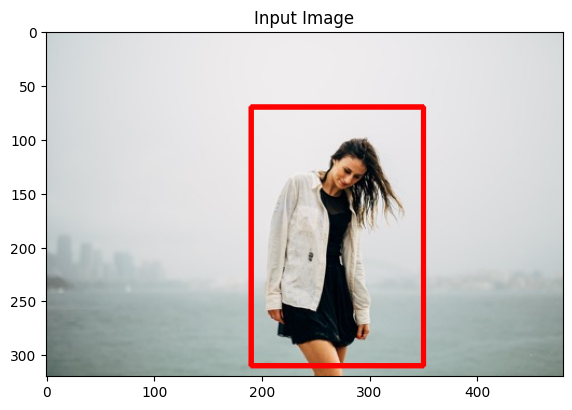

In [4]:
# Load our image
image = cv2.imread('woman.jpeg')
copy = image.copy()
# Create a mask (of zeros uint8 datatype) that is the same size (width, height) as our original image
mask = np.zeros(image.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# Needs to be set Manually or selected with cv2.selectROI()
x1, y1, x2, y2 = 190, 70, 350, 310
start = (x1, y1)
end = (x2, y2)

# Format is X,Y,W,H
rect = (x1,y1,x2-x1,y2-y1)

# Show Rectangle
cv2.rectangle(copy, start, end, (0,0,255), 3)
imshow("Input Image", copy)

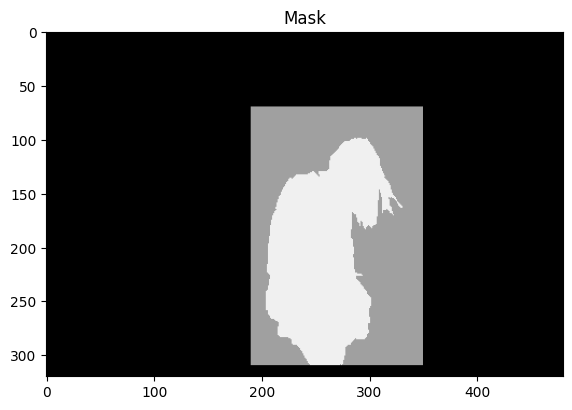

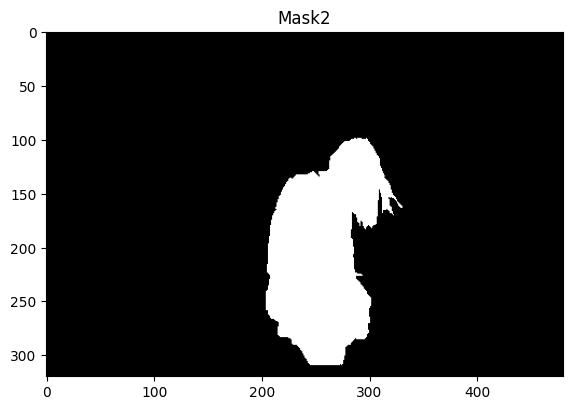

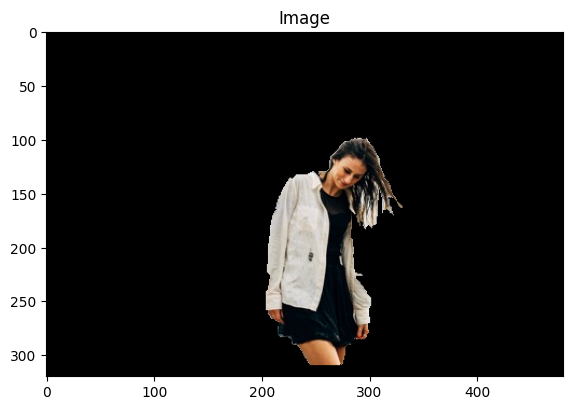

In [5]:
# Let the algorithm run for 5 iterations. Mode should be cv.GC_INIT_WITH_RECT since we are using rectangle.
# Grabcut modifies the mask image.
# In the new mask image, pixels will be marked with four flags denoting background/foreground as specified above.
# So we modify the mask such that all 0-pixels and 2-pixels are put to 0 (i.e. background) & all 1-pixels and 3-pixels are put to 1(i.e. foreground pixels).
# Now our final mask is ready. Just multiply it with input image to get the segmented image.
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
image = image * mask2[:,:,np.newaxis]

imshow("Mask", mask * 80)
imshow("Mask2", mask2 * 255)
imshow("Image", image)

## Deep Learning for Image segmentation

### Fetching the dataset for semantic Segmentation

In [6]:
from google.colab import files
# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"efreet","key":"ee10f11fe46cf9cea06b33a72a7a72d5"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d ipythonx/carvana-image-masking-png

Dataset URL: https://www.kaggle.com/datasets/ipythonx/carvana-image-masking-png
License(s): copyright-authors
100% 828M/828M [00:12<00:00, 61.6MB/s]
100% 828M/828M [00:12<00:00, 70.6MB/s]


In [12]:
import zipfile
import os

zip_file_path = 'carvana-image-masking-png.zip'
extract_dir = 'carvana-image-masking-png'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))

Streaming output truncated to the last 5000 lines.
carvana-image-masking-png/train_masks/df642435a951_11.png
carvana-image-masking-png/train_masks/32ff007d9505_10.png
carvana-image-masking-png/train_masks/6bff9e10288e_06.png
carvana-image-masking-png/train_masks/1e89e1af42e7_09.png
carvana-image-masking-png/train_masks/c4ac16c0dd59_10.png
carvana-image-masking-png/train_masks/ed13cbcdd5d8_12.png
carvana-image-masking-png/train_masks/f7ad86e13ed7_13.png
carvana-image-masking-png/train_masks/2cb91c2543fa_06.png
carvana-image-masking-png/train_masks/99639c826ea5_06.png
carvana-image-masking-png/train_masks/b98c63cd6102_02.png
carvana-image-masking-png/train_masks/9a2bfb24ba6e_09.png
carvana-image-masking-png/train_masks/7abaa38c227f_06.png
carvana-image-masking-png/train_masks/2faf504842df_13.png
carvana-image-masking-png/train_masks/1952e5f91de0_12.png
carvana-image-masking-png/train_masks/3f202616a2b9_07.png
carvana-image-masking-png/train_masks/a078586ccdee_08.png
carvana-image-masking

###Semantic Segmentation with U-Net


---
This section will go over the code for semantic segmentation. We'll look at how to create the dataset class for these tasks, the training loop, and the components that would make it differnet from classification



In [9]:
###--------Making the U-Net architecture--------###

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    """
    DoubleConv defines a module with two consecutive convolutional layers, each followed by
    batch normalization and ReLU activation.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        """
        Forward pass through the DoubleConv module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after the double convolution.
        """
        return self.conv(x)

class UNET(nn.Module):
    """
    UNET defines a U-shaped convolutional neural network architecture for image segmentation.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        features (list): List of feature channels for each level of the UNET.

    Attributes:
        ups (nn.ModuleList): List of upsampling blocks.
        downs (nn.ModuleList): List of downsampling blocks.
        pool (nn.MaxPool2d): Max pooling layer for downsampling.
        bottleneck (DoubleConv): Bottleneck block in the middle of the UNET.
        final_conv (nn.Conv2d): Final convolutional layer to produce the output.
    """

    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass through the UNET.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the UNET.
        """
        skip_connections = []

        # Downward pass through the downsampling blocks
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upward pass through the upsampling blocks
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # Resize the feature map if its size doesn't match the skip connection's size
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate the skip connection and the upsampled feature map
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    """
    Function to test the UNET model with a sample input tensor.
    """
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape


In [10]:
###import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import os


class CarvanaDataset(Dataset):
    """
    Custom dataset class for the Carvana image segmentation dataset.

    Args:
        image_dir (str): Directory containing the input images.
        mask_dir (str): Directory containing the corresponding masks.
        transform (callable, optional): Optional transform to be applied to the image and mask.

    Attributes:
        image_dir (str): Directory containing the input images.
        mask_dir (str): Directory containing the corresponding masks.
        transform (callable, optional): Optional transform to be applied to the image and mask.
        images (list): List of image filenames in the dataset.
    """

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(mask_dir)

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.images)

    def __getitem__(self, index):
        """
        Get a specific sample from the dataset.

        Args:
            index (int): Index of the sample.

        Returns:
            tuple: Tuple containing the image and its corresponding mask.
        """
        # Get file paths
        img_path = os.path.join(self.image_dir, self.images[index].replace(".png", ".jpg"))
        mask_path = os.path.join(self.mask_dir, self.images[index])

        # Load image and mask as numpy arrays
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        # Convert mask values to binary (0 or 1)
        mask[mask == 255.0] = 1.0

        # Apply transformations if specified
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [11]:
import torch
import torchvision
from torch.utils.data import DataLoader, random_split

###---------utils---------###

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    """
    Save model checkpoint to a file.

    Args:
        state (dict): Dictionary containing model state, optimizer state, and other metadata.
        filename (str): Name of the file to save the checkpoint.
    """
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    """
    Load model weights from a checkpoint.

    Args:
        checkpoint (dict): Dictionary containing model state, optimizer state, and other metadata.
        model (torch.nn.Module): Model to load the weights into.
    """
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    # val_dir,
    # val_maskdir,
    batch_size,
    # train_transform,
    transforms,
    num_workers=4,
    pin_memory=True,
):
    """
    Create DataLoader instances for training and validation datasets.

    Args:
        train_dir (str): Directory containing training images.
        train_maskdir (str): Directory containing training masks.
        val_dir (str): Directory containing validation images.
        val_maskdir (str): Directory containing validation masks.
        batch_size (int): Batch size for DataLoader.
        train_transform (callable): Transformations to be applied to the training data.
        val_transform (callable): Transformations to be applied to the validation data.
        num_workers (int): Number of worker processes for data loading.
        pin_memory (bool): Whether to use pinned memory for DataLoader.

    Returns:
        DataLoader: DataLoader for training dataset.
        DataLoader: DataLoader for validation dataset.
    """


    dataset = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=transforms,
    )

    n_val = int(len(dataset) * 0.8)
    n_train = len(dataset) - n_val

    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # train_loader = DataLoader(
    #     train_ds,
    #     batch_size=batch_size,
    #     num_workers=num_workers,
    #     pin_memory=pin_memory,
    #     shuffle=True,
    # )

    # val_ds = CarvanaDataset(
    #     image_dir=val_dir,
    #     mask_dir=val_maskdir,
    #     transform=val_transform,
    # )

    # val_loader = DataLoader(
    #     val_ds,
    #     batch_size=batch_size,
    #     num_workers=num_workers,
    #     pin_memory=pin_memory,
    #     shuffle=False,
    # )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    """
    Check accuracy and dice score of the model on a given DataLoader.

    Args:
        loader (DataLoader): DataLoader containing the data for evaluation.
        model (torch.nn.Module): Model to evaluate.
        device (str): Device to use for evaluation.

    Returns:
        None
    """
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    """
    Save model predictions and ground truth images to a folder.

    Args:
        loader (DataLoader): DataLoader containing the data for prediction.
        model (torch.nn.Module): Model for making predictions.
        folder (str): Directory to save the predicted images.
        device (str): Device to use for prediction.

    Returns:
        None
    """
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/{idx}.png")

    model.train()


In [16]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
# from model import UNET
# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     get_loaders,
#     check_accuracy,
#     save_predictions_as_imgs,
# )

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 1
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "./carvana-image-masking-png/train_images/"
TRAIN_MASK_DIR = "./carvana-image-masking-png/train_masks/"
# VAL_IMG_DIR = "data/val_images/"
# VAL_MASK_DIR = "data/val_masks/"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    """
    Training function for a single epoch.

    Args:
        loader (DataLoader): DataLoader for the training dataset.
        model (torch.nn.Module): Model to be trained.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        loss_fn (torch.nn.Module): Loss function for calculating the training loss.
        scaler (torch.cuda.amp.GradScaler): Gradient scaler for mixed-precision training.

    Returns:
        None
    """
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def main():
    """
    Main training script.

    Returns:
        None
    """
    # train_transform = A.Compose(
    #     [
    #         A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    #         A.Rotate(limit=35, p=1.0),
    #         A.HorizontalFlip(p=0.5),
    #         A.VerticalFlip(p=0.1),
    #         A.Normalize(
    #             mean=[0.0, 0.0, 0.0],
    #             std=[1.0, 1.0, 1.0],
    #             max_pixel_value=255.0,
    #         ),
    #         ToTensorV2(),
    #     ],
    # )

    transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        # VAL_IMG_DIR,
        # VAL_MASK_DIR,
        BATCH_SIZE,
        # train_transform,
        transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="./saved_images/", device=DEVICE
        )


In [17]:
main()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Got 123228432/156057600 with acc 78.96
Dice score: 0.0


100%|██████████| 64/64 [00:29<00:00,  2.14it/s, loss=0.271]


=> Saving checkpoint
Got 153318015/156057600 with acc 98.24
Dice score: 0.9567745923995972


100%|██████████| 64/64 [00:31<00:00,  2.03it/s, loss=0.247]


=> Saving checkpoint
Got 154172273/156057600 with acc 98.79
Dice score: 0.9710095524787903


100%|██████████| 64/64 [00:31<00:00,  2.04it/s, loss=0.212]


=> Saving checkpoint
Got 154724306/156057600 with acc 99.15
Dice score: 0.9796739220619202


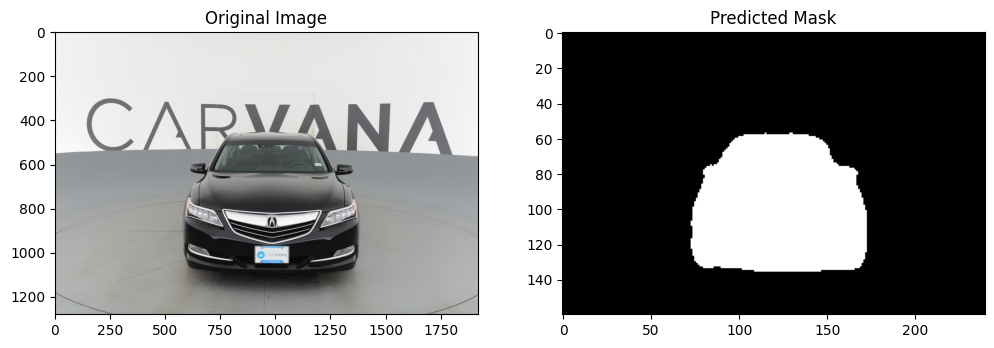

In [26]:
###--------------Inference script------------###

import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Load the trained model

model = UNET(in_channels=3, out_channels=1).to(DEVICE)

checkpoint = torch.load('my_checkpoint.pth.tar', map_location=DEVICE)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

def perform_semantic_segmentation(model, image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(image=np.array(img))['image'].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
    # print(f"Model output shape: {output.shape}")
    # print(f"Model output min: {output.min()}, max: {output.max()}")
    probabilities = torch.sigmoid(output)
    # print(f"Probabilities shape: {probabilities.shape}")
    predicted_class = (probabilities > 0.5).float()
    predicted_class = predicted_class.squeeze().cpu().numpy()

    return img, predicted_class

image_path = './carvana-image-masking-png/train_images/00087a6bd4dc_01.jpg'
original_img, mask = perform_semantic_segmentation(model, image_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img)

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(mask, cmap='gray')

plt.show()